# Team Assignment - Intentionally Blank

The following libraries should be installed before proceeding further:
- pandas
- numpy
- **folium**
- **branca** (Should automatically be installed with folium)

In [2]:
#Import all necessary libraries

import pandas as pd
import numpy as np
from datetime import datetime

# also import these "new" libraries 
# Note: you may have to download an add them to your environment (using e.g. 'conda install -c conda-forge folium')
# !important! Install this version of plotly=5.10.0 or else some maps and animations do not render correctly
import plotly.express as px
import folium
import math
from folium import plugins
from folium.plugins import HeatMap
from branca.element import Figure

import matplotlib.pyplot as plt

from sklearn.linear_model import \
    Lasso, Ridge
from sklearn.preprocessing import \
    StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor

In addition to the available datasets from the team assignment the original dataset is read for additional information about each ride. The additional information contains the geographical coordinates for the start position and the end position of each ride.

In [3]:
# Reading in weather and philadelphia_2017 data
df_weather = pd.read_csv("data/weather_hourly_philadelphia.csv")
df_philadelphia_2017 = pd.read_csv("data/philadelphia_2017.csv")

# Additionally read the philadelphia data from the official website
data_philadelphia_2017_Q1 = pd.read_csv("data/indego_Q1_2017.csv")
data_philadelphia_2017_Q2 = pd.read_csv("data/indego_Q2_2017.csv")
data_philadelphia_2017_Q3 = pd.read_csv("data/indego_Q3_2017.csv")
data_philadelphia_2017_Q4 = pd.read_csv("data/indego_Q4_2017.csv")

## Preparing and cleaning data

### Preparing and cleaning the philadelphia datasets

In [4]:
# Concatenate all quarters of philadelphia data and convert them to a dataframe
df_philadelphia_website = pd.concat([data_philadelphia_2017_Q1, data_philadelphia_2017_Q2, data_philadelphia_2017_Q3, data_philadelphia_2017_Q4], ignore_index=True)

In [5]:
# Dropping the columns duration, start_station_id, end_station_id, plan_duration, trip_route_category, passholder_type, start_station, end_station
df_philadelphia_website.drop(['duration', 'start_station_id', 'end_station_id', 'plan_duration', 'trip_route_category', 'passholder_type', 'start_station', 'end_station', 'trip_id'], axis=1, inplace=True)
df_philadelphia_website

#Changing the type of start_time, end_time (df_philadelphia_2017 and df_philadelphia_website) and date_time (df_weather) to datetime type from pandas
df_philadelphia_website.loc[:,'start_time'] = pd.to_datetime(df_philadelphia_website['start_time'])
df_philadelphia_website.loc[:,'end_time'] = pd.to_datetime(df_philadelphia_website['end_time'])

df_philadelphia_2017.loc[:,'start_time'] = pd.to_datetime(df_philadelphia_2017['start_time'])
df_philadelphia_2017.loc[:,"end_time"] = pd.to_datetime(df_philadelphia_2017["end_time"])

#Sort dataframes by their corresponding time column
df_philadelphia_website.sort_values(["start_time"], inplace = True)
df_philadelphia_2017.sort_values(["start_time"], inplace = True)


#Resetting the indexes
df_philadelphia_website.reset_index(drop = True, inplace = True)
df_philadelphia_2017.reset_index(drop = True, inplace = True)

Before we further clean the dataset for philadelphia its important to mention that we first deleted the irrelevant stations because some duplicate rows happen to have the same start time, end time and bike ids but different start and end stations like the "Virtual Station". Therefore we deleted those stations first to avoid deleting useful records. In the following example you can see that deleting the duplicates first could lead to deleting useful records and keeping irrelevant records which are deleted either way later.

In [6]:
df_philadelphia_2017[df_philadelphia_2017.duplicated(subset=['start_time', 'end_time', 'bike_id'], keep=False)].head(6)

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name
255753,2017-06-05 15:26:00,2017-06-05 15:27:00,3152,3152,11907,Indego30,"40th & Baltimore, Trolley Portal","40th & Baltimore, Trolley Portal"
255755,2017-06-05 15:26:00,2017-06-05 15:27:00,3000,3000,11907,Indego30,Virtual Station,Virtual Station
256143,2017-06-05 17:26:00,2017-06-05 17:31:00,3152,3024,11907,Walk-up,"40th & Baltimore, Trolley Portal","43rd & Chester, Clark Park"
256148,2017-06-05 17:26:00,2017-06-05 17:31:00,3000,3024,11907,Walk-up,Virtual Station,"43rd & Chester, Clark Park"
258113,2017-06-06 16:02:00,2017-06-06 16:33:00,3004,3000,5314,Indego30,Municipal Services Building Plaza,Virtual Station
258115,2017-06-06 16:02:00,2017-06-06 16:33:00,3004,3161,5314,Indego30,Municipal Services Building Plaza,30th Street Station East


The "3083" station does not exist as a real station. Furthermore the "Virtual Station" is used by staff to check in or check out a bike remotely for an event or when the bike was not properly checked in or out. Therefore we check the number of rows where one of those stations occur and delete those rows afterwards.

For further information please check the official site about the data and the station table [here](https://www.rideindego.com/about/data/).

In [7]:
print(r'Number of rows in df_philadelphia_2017 with "Virtual Station" and "3083" in the start station or end station: ',
 df_philadelphia_2017[(df_philadelphia_2017["start_station_name"] == "Virtual Station") | (df_philadelphia_2017["end_station_name"] == "Virtual Station") |
  (df_philadelphia_2017["start_station_name"] == "3083") | (df_philadelphia_2017["end_station_name"] == "3083")
  ].shape[0])

Number of rows in df_philadelphia_2017 with "Virtual Station" and "3083" in the start station or end station:  6512


In [8]:
# Deleting "Virtual Station" and "3083" from the start_station_name and end_station_name columns
df_philadelphia_2017 = df_philadelphia_2017[(df_philadelphia_2017["start_station_name"] != "3083") & (df_philadelphia_2017["end_station_name"] != "3083") ]
df_philadelphia_2017 = df_philadelphia_2017[(df_philadelphia_2017["start_station_name"] != "Virtual Station") & (df_philadelphia_2017["end_station_name"] != "Virtual Station") ]

display(df_philadelphia_2017[(df_philadelphia_2017["start_station_name"] == "Virtual Station") | (df_philadelphia_2017["end_station_name"] == "Virtual Station") | (df_philadelphia_2017["start_station_name"] == "3083") | (df_philadelphia_2017["end_station_name"] == "3083")])

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name


The "bike_id" should be unique to one bike. No trip with the same bike_id should start and end on the same time interval. 

In [9]:
#Checking for any duplicates in philadelphia data
print("Number of duplicates in df_philadelphia_2017: ", df_philadelphia_2017.duplicated(subset=['start_time', 'end_time', 'bike_id']).sum())
print("Number of duplicates in df_philadelphia_website: ", df_philadelphia_website.duplicated(subset=['start_time', 'end_time', 'bike_id']).sum())

Number of duplicates in df_philadelphia_2017:  55
Number of duplicates in df_philadelphia_website:  68


In [10]:
#Dropping all duplicates for the philadelphia data depending on the start_time, end_time and bike_id
df_philadelphia_2017.drop_duplicates(subset=["start_time", "end_time", "bike_id"], keep="first", inplace=True)
df_philadelphia_website.drop_duplicates(subset=["start_time", "end_time", "bike_id"], keep="first", inplace=True)

display(df_philadelphia_2017[df_philadelphia_2017.duplicated(subset=['start_time', 'end_time', 'bike_id'])].head(10))
display(df_philadelphia_website[df_philadelphia_website.duplicated(subset=['start_time', 'end_time', 'bike_id'])].head(10))

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name


,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id


In [11]:
# Joining df_philadelphia_2017 with df_philadelphia_full on start_time, end_time, bike_id and dropping duplicate columns
df_philadelphia_2017_joined = df_philadelphia_2017.merge(df_philadelphia_website, on=["start_time", "end_time", "bike_id"], how="left")

df_philadelphia_2017_joined

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon
0,2017-01-01 00:05:00,2017-01-01 00:16:00,3046,3041,5347,Indego30,2nd & Market,"Girard Station, MFL",39.950119,-75.144722,39.968491,-75.135460
1,2017-01-01 00:21:00,2017-01-01 00:57:00,3110,3054,3364,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202
2,2017-01-01 00:22:00,2017-01-01 00:57:00,3110,3054,2536,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202
3,2017-01-01 00:27:00,2017-01-01 00:39:00,3041,3005,5176,Indego30,"Girard Station, MFL","Welcome Park, NPS",39.968491,-75.135460,39.947330,-75.144028
4,2017-01-01 00:28:00,2017-01-01 00:36:00,3047,3124,5370,Walk-up,"Independence Mall, NPS",Race Street Pier,39.950710,-75.149208,39.952950,-75.139793
...,...,...,...,...,...,...,...,...,...,...,...,...
782335,2017-12-31 23:05:00,2017-12-31 23:33:00,3070,3124,3708,Indego30,"Spring Garden Station, MFL",Race Street Pier,39.960621,-75.139832,39.952950,-75.139793
782336,2017-12-31 23:11:00,2018-01-01 11:03:00,3107,3165,5117,Indego30,33rd & Reservoir,24th & Race SRT,39.982029,-75.188660,39.958191,-75.178200
782337,2017-12-31 23:18:00,2017-12-31 23:25:00,3033,3046,11933,Indego30,10th & Chestnut,2nd & Market,39.950050,-75.156723,39.950119,-75.144722
782338,2017-12-31 23:39:00,2017-12-31 23:40:00,3163,3163,6725,Indego30,25th & Locust,25th & Locust,39.949741,-75.180969,39.949741,-75.180969


In [12]:
#Checking for missing values in philadelphia data
display(df_philadelphia_2017_joined[df_philadelphia_2017_joined.isnull().any(axis = 1)])

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon
255784,2017-06-06 16:02:00,2017-06-06 16:33:00,3004,3161,5314,Indego30,Municipal Services Building Plaza,30th Street Station East,39.953781,-75.163742,NaN,NaN
613438,2017-10-05 08:35:00,2017-10-05 08:47:00,3111,3107,5306,Indego30,"Parkside & Belmont, Case Building",33rd & Reservoir,NaN,NaN,39.982029,-75.18866
613848,2017-10-05 10:31:00,2017-10-05 10:53:00,3095,3111,5329,Indego30,29th & Diamond,"Parkside & Belmont, Case Building",39.987709,-75.180519,NaN,NaN


In [13]:
df_philadelphia_2017_joined.dropna(inplace = True)	

In [14]:
#Adding hour, month, weekday and trip duration(based on start and end time) to the table
df_philadelphia_2017_joined.loc[:,"trip_duration"] = df_philadelphia_2017_joined["end_time"] - df_philadelphia_2017_joined["start_time"] 
df_philadelphia_2017_joined.loc[:,"month"] = df_philadelphia_2017_joined["start_time"].dt.month
df_philadelphia_2017_joined.loc[:,"week"] = df_philadelphia_2017_joined["start_time"].dt.isocalendar().week
df_philadelphia_2017_joined.loc[:,"weekday"] = df_philadelphia_2017_joined["start_time"].dt.weekday
df_philadelphia_2017_joined.loc[:,"day"] = df_philadelphia_2017_joined["start_time"].dt.day
df_philadelphia_2017_joined.loc[:,"hour"] = df_philadelphia_2017_joined["start_time"].dt.hour
df_philadelphia_2017_joined

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,month,week,weekday,day,hour
0,2017-01-01 00:05:00,2017-01-01 00:16:00,3046,3041,5347,Indego30,2nd & Market,"Girard Station, MFL",39.950119,-75.144722,39.968491,-75.135460,0 days 00:11:00,1,52,6,1,0
1,2017-01-01 00:21:00,2017-01-01 00:57:00,3110,3054,3364,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202,0 days 00:36:00,1,52,6,1,0
2,2017-01-01 00:22:00,2017-01-01 00:57:00,3110,3054,2536,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202,0 days 00:35:00,1,52,6,1,0
3,2017-01-01 00:27:00,2017-01-01 00:39:00,3041,3005,5176,Indego30,"Girard Station, MFL","Welcome Park, NPS",39.968491,-75.135460,39.947330,-75.144028,0 days 00:12:00,1,52,6,1,0
4,2017-01-01 00:28:00,2017-01-01 00:36:00,3047,3124,5370,Walk-up,"Independence Mall, NPS",Race Street Pier,39.950710,-75.149208,39.952950,-75.139793,0 days 00:08:00,1,52,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782335,2017-12-31 23:05:00,2017-12-31 23:33:00,3070,3124,3708,Indego30,"Spring Garden Station, MFL",Race Street Pier,39.960621,-75.139832,39.952950,-75.139793,0 days 00:28:00,12,52,6,31,23
782336,2017-12-31 23:11:00,2018-01-01 11:03:00,3107,3165,5117,Indego30,33rd & Reservoir,24th & Race SRT,39.982029,-75.188660,39.958191,-75.178200,0 days 11:52:00,12,52,6,31,23
782337,2017-12-31 23:18:00,2017-12-31 23:25:00,3033,3046,11933,Indego30,10th & Chestnut,2nd & Market,39.950050,-75.156723,39.950119,-75.144722,0 days 00:07:00,12,52,6,31,23
782338,2017-12-31 23:39:00,2017-12-31 23:40:00,3163,3163,6725,Indego30,25th & Locust,25th & Locust,39.949741,-75.180969,39.949741,-75.180969,0 days 00:01:00,12,52,6,31,23


We also remove trips which are shorter than one minute and longer than one day because the bike sharing service does not allow those trips normally.

In [15]:
df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] < "0 days 00:01:00"]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,month,week,weekday,day,hour
699155,2017-11-05 01:35:00,2017-11-05 01:03:00,3118,3111,6694,Indego30,"46th Street Station, MFL","Parkside & Belmont, Case Building",39.958660,-75.213226,39.977791,-75.213226,-1 days +23:28:00,11,44,6,5,1
699158,2017-11-05 01:39:00,2017-11-05 01:35:00,3066,3066,2551,Indego30,19th & Lombard,19th & Lombard,39.945610,-75.173477,39.945610,-75.173477,-1 days +23:56:00,11,44,6,5,1
699163,2017-11-05 01:51:00,2017-11-05 01:20:00,3157,3041,11750,Indego30,"8th & Mifflin, Bok Building","Girard Station, MFL",39.925449,-75.159538,39.968491,-75.135460,-1 days +23:29:00,11,44,6,5,1


In [16]:
df_philadelphia_2017_joined = df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] >= "0 days 00:01:00"]
df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] < "0 days 00:01:00"]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,month,week,weekday,day,hour


In [17]:
df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] > "1 days"]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,month,week,weekday,day,hour
682,2017-01-01 18:19:00,2017-01-03 08:04:00,3072,3125,5354,Walk-up,Front & Carpenter,15th & South,39.934448,-75.145409,39.943909,-75.167351,1 days 13:45:00,1,52,6,1,18
20987,2017-01-23 15:19:00,2017-01-24 16:14:00,3038,3028,2492,Indego30,The Children's Hospital of Philadelphia (CHOP),4th & Bainbridge,39.947811,-75.194092,39.940609,-75.149582,1 days 00:55:00,1,4,0,23,15
24873,2017-01-26 17:31:00,2017-01-28 10:00:00,3021,3109,5185,Indego30,18th & JFK,Parkside & Girard,39.953899,-75.169022,39.974861,-75.205238,1 days 16:29:00,1,4,3,26,17
27216,2017-01-28 15:46:00,2017-01-30 08:01:00,3012,3034,5255,Walk-up,21st & Catharine,11th & Reed,39.942181,-75.177467,39.933151,-75.162483,1 days 16:15:00,1,4,5,28,15
32762,2017-02-02 09:45:00,2017-02-03 17:59:00,3054,3021,5125,Indego30,Rodin Museum,18th & JFK,39.962502,-75.174202,39.953899,-75.169022,1 days 08:14:00,2,5,3,2,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735895,2017-11-25 12:12:00,2017-11-27 07:31:00,3112,3020,11894,Indego30,48th & Spruce,University City Station,39.953732,-75.218246,39.949219,-75.190361,1 days 19:19:00,11,47,5,25,12
749711,2017-12-02 13:00:00,2017-12-03 14:12:00,3040,3073,11928,Walk-up,17th & Spring Garden,9th & Spring Garden,39.962891,-75.166061,39.961430,-75.152420,1 days 01:12:00,12,48,5,2,13
763091,2017-12-11 11:46:00,2017-12-12 13:15:00,3018,3037,3367,Indego30,12th & Filbert,Pennsylvania Convention Center,39.952728,-75.159790,39.954239,-75.161377,1 days 01:29:00,12,50,0,11,11
768955,2017-12-15 19:27:00,2017-12-17 16:32:00,3026,3072,11932,Indego30,2nd & South,Front & Carpenter,39.941380,-75.145638,39.934448,-75.145409,1 days 21:05:00,12,50,4,15,19


In [18]:
df_philadelphia_2017_joined = df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] <= "1 days"]
df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] > "1 days"]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,month,week,weekday,day,hour


In [19]:
df_philadelphia_cleaned = df_philadelphia_2017_joined.copy()
df_philadelphia_cleaned

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,month,week,weekday,day,hour
0,2017-01-01 00:05:00,2017-01-01 00:16:00,3046,3041,5347,Indego30,2nd & Market,"Girard Station, MFL",39.950119,-75.144722,39.968491,-75.135460,0 days 00:11:00,1,52,6,1,0
1,2017-01-01 00:21:00,2017-01-01 00:57:00,3110,3054,3364,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202,0 days 00:36:00,1,52,6,1,0
2,2017-01-01 00:22:00,2017-01-01 00:57:00,3110,3054,2536,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202,0 days 00:35:00,1,52,6,1,0
3,2017-01-01 00:27:00,2017-01-01 00:39:00,3041,3005,5176,Indego30,"Girard Station, MFL","Welcome Park, NPS",39.968491,-75.135460,39.947330,-75.144028,0 days 00:12:00,1,52,6,1,0
4,2017-01-01 00:28:00,2017-01-01 00:36:00,3047,3124,5370,Walk-up,"Independence Mall, NPS",Race Street Pier,39.950710,-75.149208,39.952950,-75.139793,0 days 00:08:00,1,52,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782335,2017-12-31 23:05:00,2017-12-31 23:33:00,3070,3124,3708,Indego30,"Spring Garden Station, MFL",Race Street Pier,39.960621,-75.139832,39.952950,-75.139793,0 days 00:28:00,12,52,6,31,23
782336,2017-12-31 23:11:00,2018-01-01 11:03:00,3107,3165,5117,Indego30,33rd & Reservoir,24th & Race SRT,39.982029,-75.188660,39.958191,-75.178200,0 days 11:52:00,12,52,6,31,23
782337,2017-12-31 23:18:00,2017-12-31 23:25:00,3033,3046,11933,Indego30,10th & Chestnut,2nd & Market,39.950050,-75.156723,39.950119,-75.144722,0 days 00:07:00,12,52,6,31,23
782338,2017-12-31 23:39:00,2017-12-31 23:40:00,3163,3163,6725,Indego30,25th & Locust,25th & Locust,39.949741,-75.180969,39.949741,-75.180969,0 days 00:01:00,12,52,6,31,23


### Preparing and cleaning the weather dataset

After preparing and cleaning the philadelphia dataset we need to do most of the procedure on the weather dataset.

In [20]:
#Changing the type of date_time (df_weather) to datetime type from pandas
df_weather.loc[:, "date_time"] = pd.to_datetime(df_weather["date_time"])

#Sort the dataframe by their corresponding time column
df_weather.sort_values(["date_time"], inplace = True)

#Reset the index
df_weather.reset_index(drop = True, inplace =True)

First of all we check for duplicate rows in the weather data and delete them if they occur because we do not need multiple rows multiple times.

In [21]:
#Checking for any duplicates in weather data
print("Number of duplicates in df_weather: ", df_weather.duplicated().sum())

Number of duplicates in df_weather:  630


In [22]:
#Dropping all duplicates for the weather data
df_weather.drop_duplicates(subset= ["date_time"],inplace = True)

display(df_weather[df_weather.duplicated()])

,date_time,max_temp,min_temp,precip


We also check for null values in the weather data and delete them. It is important to note that we later add additional rows with null values but with the missing time intervals because we can interpolate them with the interpolate function in pandas.

In [23]:
#Checking for missing values in weather and philadelphia data
display(df_weather[df_weather.isnull().any(axis = 1)])

,date_time,max_temp,min_temp,precip
43785,NaT,NaN,NaN,NaN


In [24]:
#Add missing intervals in the weather data
df_weather.index = df_weather["date_time"]
df_weather

,date_time,max_temp,min_temp,precip
date_time,,,,
2015-01-01 06:00:00,2015-01-01 06:00:00,-1.7,-1.7,0.0
2015-01-01 07:00:00,2015-01-01 07:00:00,-1.7,-1.7,0.0
2015-01-01 08:00:00,2015-01-01 08:00:00,-1.7,-1.7,0.0
2015-01-01 09:00:00,2015-01-01 09:00:00,-1.1,-1.1,0.0
2015-01-01 10:00:00,2015-01-01 10:00:00,-1.1,-1.1,0.0
...,...,...,...,...
2020-01-02 02:00:00,2020-01-02 02:00:00,1.1,1.1,0.0
2020-01-02 03:00:00,2020-01-02 03:00:00,0.6,0.6,0.0
2020-01-02 04:00:00,2020-01-02 04:00:00,-0.6,-0.6,0.0


In [25]:
#Checking for missing values in weather data
display(df_weather[df_weather.isnull().any(axis = 1)])

,date_time,max_temp,min_temp,precip
date_time,,,,
NaT,NaT,NaN,NaN,NaN


In [26]:
df_weather.dropna(inplace = True)

Since the weather data consists of data from the beginning of 2015 until the end of 2019, we want to have as well only the weather data for 2017.

In [27]:
#Selecting data from the beginning of 2017 till the end of 2017
df_weather_2017 = df_weather[(df_weather["date_time"]>= "2017-01-01 00:00:00") & (df_weather["date_time"]< "2018-01-01 00:00:00" )]

In [28]:
#Add missing intervals in the weather data
df_weather_2017.set_index("date_time", inplace = True)
df_weather_2017 = df_weather_2017.resample("H").asfreq()

The minimum temperature and maximum temperature will be interpolated linearly. The precipitation value is interpolated by taking one of the nearest existing values.

In [29]:
# Interpolate missing values in the weather data
df_weather_2017["min_temp"].interpolate(method = "linear", inplace = True)
df_weather_2017["max_temp"].interpolate(method = "linear", inplace = True)
df_weather_2017["precip"].interpolate(method = "pad", inplace = True)
df_weather_2017.reset_index(drop=False, inplace = True)

# Check if null values in the weather data still exist
display(df_weather_2017[df_weather_2017.isnull().any(axis = 1)])
display(df_weather_2017)

,date_time,max_temp,min_temp,precip


,date_time,max_temp,min_temp,precip
0,2017-01-01 00:00:00,6.1,6.1,0.0
1,2017-01-01 01:00:00,6.1,6.1,0.0
2,2017-01-01 02:00:00,6.7,6.7,0.0
3,2017-01-01 03:00:00,7.2,7.2,0.0
4,2017-01-01 04:00:00,7.8,7.8,0.0
...,...,...,...,...
8755,2017-12-31 19:00:00,-8.9,-8.9,0.0
8756,2017-12-31 20:00:00,-8.9,-8.9,0.0
8757,2017-12-31 21:00:00,-9.4,-9.4,0.0
8758,2017-12-31 22:00:00,-10.0,-10.0,0.0


All dataframes for reference:
* **Philadelphia data**
   * *df_philadelphia_cleaned*
* **Weather data**
   * *df_weather_2017*

### KPI Coverage/Geographical Demand Patterns(?)

In the next part we use the geographical coordinates of the original dataset from the indego website.

First of all we create a dataframe where we group the rows by the start station and the corresponding coordinates. Furthermore we aggregate the rows into a new column "counts".

In [30]:
phil_groupedby_start = df_philadelphia_cleaned.groupby([ 'start_station_name', 'start_lat', 'start_lon']).size().reset_index(name='counts')

phil_groupedby_start

,start_station_name,start_lat,start_lon,counts
0,10th & Chestnut,39.950050,-75.156723,8441
1,10th & Federal,39.934311,-75.160423,4664
2,"11th & Pine, Kahn Park",39.945171,-75.159927,12025
3,"11th & Poplar, John F. Street Community Center",39.968922,-75.154701,743
4,11th & Reed,39.933151,-75.162483,7777
...,...,...,...,...
125,"The Children's Hospital of Philadelphia, Osler...",39.946812,-75.193108,4032
126,"Thompson & Palmer, Adaire School",39.972160,-75.129936,1472
127,University City Station,39.948872,-75.189857,6919
128,University City Station,39.949219,-75.190361,9020


We plot the number of trips per start station. For visualizing which stations stations have the most demand. For this we use circle markers to visualize each station. Bigger circle markers indicate more rented bikes for the corresponding station and clicking on a specific marker reveals additional information like the specific trip count and the station name.

In [31]:
figure_start_station = Figure(width=950,height=900) 
map_start_station = folium.Map(dragging=True,zoom_control=True, control_scale=True, max_zoom=18, min_zoom=13,scrollWheelZoom=False,doubleClickZoom=False, width=900,height=800)
for index, row in phil_groupedby_start.iterrows():
    iframe = folium.IFrame(f"Station name: {row['start_station_name']} <br> Trips per station :  {row['counts']}", width=250, height=70)
    popup = folium.Popup(iframe)
    folium.Circle([row['start_lat'], row['start_lon']], radius=math.sqrt(row['counts']), color='red', fill_color='orange', fill_opacity=0.3, popup=popup).add_to(map_start_station)
south_west_b = phil_groupedby_start[['start_lat', 'start_lon']].min().values.tolist()
north_east_b = phil_groupedby_start[['start_lat', 'start_lon']].max().values.tolist()
map_start_station.fit_bounds([south_west_b, north_east_b])
figure_start_station.add_child(map_start_station)
title = '''<h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format("Number of trips per start station")   
map_start_station.get_root().html.add_child(folium.Element(title))
figure_start_station

As we can see most bikes are rented in stations near the center of philadelphia like "18th & JFK", "Rittenhouse Square" and "15th & Market" but also near main roads like the stations "15th & Spruce", "Rodin Museum" and "23rd & South". More possibilities why some stations could be more used are hotspots like Museums for example the "Rodin Museum" or the "Philadelphia Museum of Art".

Now we do the same procedure for the end stations, first grouping them like in the previous steps.

In [32]:
phil_groupedby_end = df_philadelphia_cleaned.groupby([ 'end_station_name', 'end_lat', 'end_lon']).size().reset_index(name='counts')

phil_groupedby_end

,end_station_name,end_lat,end_lon,counts
0,10th & Chestnut,39.950050,-75.156723,8724
1,10th & Federal,39.934311,-75.160423,4938
2,"11th & Pine, Kahn Park",39.945171,-75.159927,12458
3,"11th & Poplar, John F. Street Community Center",39.968922,-75.154701,772
4,11th & Reed,39.933151,-75.162483,8265
...,...,...,...,...
125,"The Children's Hospital of Philadelphia, Osler...",39.946812,-75.193108,3815
126,"Thompson & Palmer, Adaire School",39.972160,-75.129936,1475
127,University City Station,39.948872,-75.189857,6106
128,University City Station,39.949219,-75.190361,8558


In [33]:
figure_end_station = Figure(width=950,height=900) 
map_end_station = folium.Map(dragging=True,zoom_control=True, control_scale=True, max_zoom=18, min_zoom=13,scrollWheelZoom=False,doubleClickZoom=False, width=900,height=800)
for index, row in phil_groupedby_end.iterrows():
    iframe = folium.IFrame(f"Station name: {row['end_station_name']} <br> Trips per station :  {row['counts']}", width=250, height=70)
    popup = folium.Popup(iframe)
    folium.Circle([row['end_lat'], row['end_lon']], radius=math.sqrt(row['counts']), color='red', fill_color='orange', fill_opacity=0.3, popup=popup).add_to(map_end_station)
south_west_b = phil_groupedby_end[['end_lat', 'end_lon']].min().values.tolist()
north_east_b = phil_groupedby_end[['end_lat', 'end_lon']].max().values.tolist()
map_end_station.fit_bounds([south_west_b, north_east_b])
figure_end_station.add_child(map_end_station)
title = '''<h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format("Trips per end station")   
map_end_station.get_root().html.add_child(folium.Element(title))
figure_end_station

As we can see the overall pattern stays the same. In the center of the city are the more popular stations and going further away from the center are the least popular stations. The least popular stations could be combined with other stations near it to save maintainance costs spacing the stations out the farther they are away from the center of philadelphia.

It is also interesting to see how much the stations cover the area of philadelphia. Therefore we loaded Geojson data of the philadelphia neighborhoods and their borders to visualize which parts of philadelphia are covered by the stations.

In [34]:
figure_end_station = Figure(width=950,height=900) 
map_with_geoJson = folium.Map(location=[39.96,-75.18],dragging=True,zoom_start=12,zoom_control=True, control_scale=True, max_zoom=18, min_zoom=12,scrollWheelZoom=False,doubleClickZoom=False, width=900,height=800)
folium.GeoJson(data="data/Neighborhoods_Philadelphia.geojson").add_to(map_with_geoJson)

for index, row in phil_groupedby_end.iterrows():
    iframe = folium.IFrame(f"Station name: {row['end_station_name']} <br> Trips per station :  {row['counts']}", width=250, height=70)
    popup = folium.Popup(iframe)
    folium.Circle([row['end_lat'], row['end_lon']], radius=math.sqrt(row['counts']), color='red', fill_color='orange', fill_opacity=0.3, popup=popup).add_to(map_with_geoJson)

south_west_b = phil_groupedby_end[['end_lat', 'end_lon']].min().values.tolist()
north_east_b = phil_groupedby_end[['end_lat', 'end_lon']].max().values.tolist()
figure_end_station.add_child(map_with_geoJson)
title = '''<h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format("Trips per end station with philadelphia neighborhood")   
map_with_geoJson.get_root().html.add_child(folium.Element(title))
figure_end_station

As we can see, mostly the center is covered by the stations and the part of south philadelphia nearest to the center. This makes sense because the center has the most demand but if the demand rises with each year it could be worth adding stations near other hotspots and farther from the center.

Furthermore we can plot the demand per hour for the start station and end stations.

In [35]:
grouped_by_start_station_hour = df_philadelphia_cleaned.groupby(['start_station_name', 'start_lat', 'start_lon', 'hour']).size().reset_index(name='counts')
fig = px.scatter_mapbox(grouped_by_start_station_hour, lat="start_lat", lon="start_lon", animation_frame="hour", 
                        size= "counts",size_max= 28,opacity=0.8, animation_group='start_station_name',
                        zoom=12.3, height=1000, width=900, hover_name="start_station_name",
                        hover_data=["start_lat", "start_lon"], title='Trips per start station for each hour')
fig.update_geos(center=dict(lon=-75.14, lat=39.96))
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(
    title={
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(
            size=18
        ))
fig

As we can see between 8:00 AM and 9:00 AM the majority of trips start outside of the center. One reason could be that the majority rents a bike to go to work or that most people live outside of the center. It is also interesting to mention that at 17:00 PM the majority of the trips start in the center or near the center. This also supports the assumption that many people use the bikes for going to work and back home from work because 17:00 PM is around the time where work ends for most people. Further research in comparing work hours and the geographical patterns could lead to more insights.

In [36]:
grouped_by_end_station_hour = df_philadelphia_cleaned.groupby(['end_station_name', 'end_lat', 'end_lon', 'hour']).size().reset_index(name='counts')
fig = px.scatter_mapbox(grouped_by_end_station_hour, lat="end_lat", lon="end_lon", animation_frame="hour", 
                        size= "counts",size_max= 27,opacity=0.8, animation_group='end_station_name',
                        zoom=12.3, height=1000, width=900, hover_name="end_station_name",
                        hover_data=["end_lat", "end_lon"], title='Trips per end station for each hour')
fig.update_geos(center=dict(lon=-75.14, lat=39.96))
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(
    title={
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(
            size=18
        ))
fig

Look at the hourly trips per end station we can see this time that between 8:00 AM and 9:00 AM most trips end near the center instead of outside like for the start stations. Like wise for 17:00 PM less trips end in the center and more trips end outside of it.

In the following we also plotted the trips per start station and end station for each month. This could be useful for observing if new stations are used sufficiently.

In [37]:
grouped_by_start_station_month = df_philadelphia_cleaned.groupby(['start_station_name', 'start_lat', 'start_lon', 'month']).size().reset_index(name='counts')
fig = px.scatter_mapbox(grouped_by_start_station_month, lat="start_lat", lon="start_lon", animation_frame="month", 
                        size= "counts",size_max= 25,opacity=0.8, animation_group='start_station_name',
                        zoom=12.3, height=1000, width=900, hover_name="start_station_name",
                        hover_data=["start_lat", "start_lon"], title='Trips per start station for each month')
fig.update_geos(center=dict(lon=-75.14, lat=39.96))
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(
    title={
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(
            size=18
        ))
fig

In [38]:
grouped_by_end_station_month = df_philadelphia_cleaned.groupby(['end_station_name', 'end_lat', 'end_lon', 'month']).size().reset_index(name='counts')
fig = px.scatter_mapbox(grouped_by_end_station_month, lat="end_lat", lon="end_lon", animation_frame="month", 
                        size= "counts",size_max= 25,opacity=0.8, animation_group='end_station_name',
                        zoom=12.3, height=1000, width=900, hover_name="end_station_name",
                        hover_data=["end_lat", "end_lon"], title='Trips per end station for each month')
fig.update_geos(center=dict(lon=-75.14, lat=39.96))
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(
    title={
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(
            size=18
        ))
fig

We could problably get further insights on the utilizations and the coverage for each station like which stations are overloaded with bikes or which stations have no bikes available if the station data existed in hourly steps for 2017. With the live data on the [indego website](https://www.rideindego.com/about/data/) which contains all of these informations this could be possible if it existed for previous years.

## Prediction

In [39]:
def weekend(date):
    if(date == 5):
        return 1
    elif(date == 6):
        return 1
    else:
        return 0

In [40]:
df_prediction_hourly = df_philadelphia_cleaned.copy()
df_prediction_full = df_philadelphia_cleaned.copy()
df_prediction_full.set_index('start_time', inplace=True)
df_prediction_hourly.set_index('start_time', inplace=True)
df_prediction_hourly['trip_duration'] = df_prediction_hourly['trip_duration'].dt.total_seconds()/60
df_prediction_hourly = df_prediction_hourly.resample('H').sum()

df_prediction_hourly = df_prediction_hourly.merge(df_weather_2017, left_index=True, right_on='date_time')
df_prediction_hourly.set_index('date_time', inplace=True)
df_prediction_hourly.drop(columns=['start_station_id', 'end_station_id', 'bike_id', 'start_lat', 'start_lon', 'end_lat', 'end_lon', 'week'], inplace=True)
df_prediction_hourly['weekday'] = df_prediction_hourly.index.weekday
df_prediction_hourly['month'] = df_prediction_hourly.index.month
df_prediction_hourly['hour'] = df_prediction_hourly.index.hour

df_prediction_trips_duration_hourly = df_prediction_hourly['trip_duration'].copy()
df_prediction_trips_hourly = df_prediction_full.resample('H').size().copy()
df_prediction_hourly.drop(columns=['trip_duration'], inplace=True)
display(df_prediction_hourly)

,month,weekday,day,hour,max_temp,min_temp,precip,weekend
date_time,,,,,,,,
2017-01-01 00:00:00,1,6,21,0,6.1,6.1,0.0,1
2017-01-01 01:00:00,1,6,25,1,6.1,6.1,0.0,1
2017-01-01 02:00:00,1,6,17,2,6.7,6.7,0.0,1
2017-01-01 03:00:00,1,6,5,3,7.2,7.2,0.0,1
2017-01-01 04:00:00,1,6,4,4,7.8,7.8,0.0,1
...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,12,6,403,19,-8.9,-8.9,0.0,1
2017-12-31 20:00:00,12,6,93,20,-8.9,-8.9,0.0,1
2017-12-31 21:00:00,12,6,248,21,-9.4,-9.4,0.0,1


In [41]:
display(df_prediction_hourly[df_prediction_hourly.isnull().any(axis = 1)])

,month,weekday,day,hour,max_temp,min_temp,precip,weekend
date_time,,,,,,,,


In [42]:
X = df_prediction_hourly.copy()
y = df_prediction_trips_hourly.copy()
sc = MinMaxScaler()
X_norm = sc.fit_transform(X)
X_norm = pd.DataFrame(X_norm, columns=X.columns)
# Do a 70-30 split first
X_train_hold, X_test, y_train_hold, y_test = train_test_split(X_norm, y, test_size=0.3,random_state=34 )

# now split X_train to achive 50-20-30 split
X_train, X_hold, y_train, y_hold = train_test_split(X_train_hold, y_train_hold, test_size=(0.2/0.7),random_state=34 )

print("length of X_train: ", len(X_train))
print("length of X_hold: ", len(X_hold))
print("length of X_test: ", len(X_test))
print("length of X_train_hold: ", len(X_train_hold))

length of X_train:  4379
length of X_hold:  1753
length of X_test:  2628
length of X_train_hold:  6132


In [43]:

def plot_prediction(X_tr, y_tr, X_te, y_pr, column):
    plt.figure(figsize = (8,6))
    plt.scatter(X_tr[column], y_tr, marker="x", c='C1')
    plt.xlabel(column)
    plt.ylabel("Trips per hour")
    plt.scatter(X_te[column], y_pr, marker="x", c='red')
    plt.legend(['Observed data', 'fitted data'])
    plt.savefig('tree.png')

In [ ]:
def lasso_regression(X_train, y_train, X_hold, y_hold, degree, plot, column, method):    #method can be r2 or MAE
    # initialize model
    lasso_reg = Lasso(alpha = degree)
    
    # fit
    lasso_reg.fit(X_train, y_train) 
    y_pred_hold = lasso_reg.predict(X_hold) 
    y_pred_train = lasso_reg.predict(X_train)
    y_pred_hold[y_pred_hold < 0] = 0
    y_pred_train[y_pred_train < 0] = 0
     # Read out attributes
    coeffs = lasso_reg.coef_         # dense np.array
    display(coeffs)
    coeffs = lasso_reg.sparse_coef_  # sparse matrix
    #display(coeffs)
    coeffs = lasso_reg.intercept_    # probably also relevant
    #display(coeffs)
    
    if(plot):
        plot_prediction(X_train, y_train, X_hold, y_pred_hold, column)
    
    if(method == "MAE"):
        errors = [mean_absolute_error(y_train, y_pred_train), mean_absolute_error(y_hold, y_pred_hold)]
        return errors
    elif(method == "r2"):
        r2_scores = [r2_score(y_train, y_pred_train), r2_score(y_hold, y_pred_hold)]
        return r2_scores
    else:
        return "Please select r2 or MAE as method"


def find_lasso_regression(X_train, y_train, X_hold, y_hold, max_value):
    
    error = []
    error_train = []
    error_hold = []
    array = np.arange(0,max_value +0.1, 0.1)
    
    for i in array:
        errors = lasso_regression(X_train, y_train, X_hold, y_hold, i, False, "weekday", "MAE")
        error_train.append(errors[0])
        error_hold.append(errors[1])
    # plot results
    plt.figure(figsize = (8,6))
    plt.plot(array, error_train, label="train")
    plt.plot(array, error_hold, label="hold")
    plt.legend()
    plt.xlabel("Number of polynomials")
    plt.ylabel("MAE")
    plt.show()

In [ ]:
#X_train.drop(columns=['month', 'weekday'], inplace=True)
#X_hold.drop(columns=['month', 'weekday'], inplace=True)
find_lasso_regression(X_train, y_train, X_hold, y_hold, 10)

NameError: name 'find_lasso_regression' is not defined

R2:  [0.6554111070746432, 0.6187894455858103]


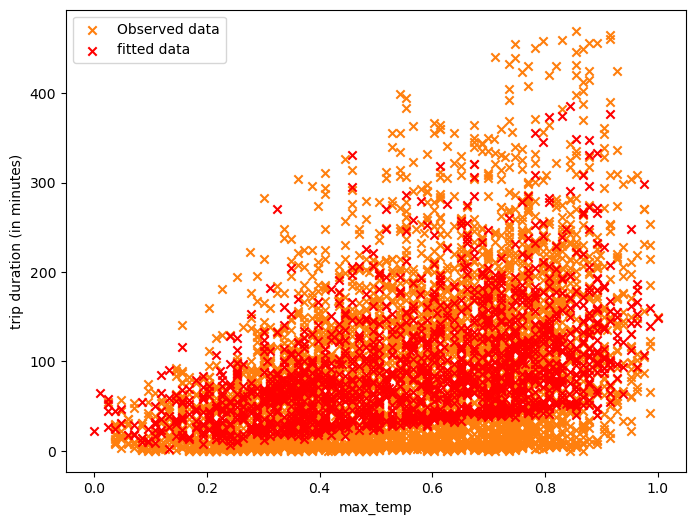

In [ ]:
print("R2: ",lasso_regression(X_train, y_train, X_hold, y_hold, 1, True, 'max_temp', 'r2'))

In [44]:
def ridge_regression(X_train, y_train, X_hold, y_hold, degree, al, plot, column, method):  #method can be r2 or MAE
    # initialize model
    poly_reg = PolynomialFeatures(degree)
    ridge_reg = Ridge(alpha = al) 
    
    # fit and transform
    X_poly = poly_reg.fit_transform(X_train)
    X_poly_hold = poly_reg.fit_transform(X_hold)

    ridge_reg.fit(X_poly, y_train)
    y_pred_hold = ridge_reg.predict(X_poly_hold)
    y_pred_train = ridge_reg.predict(X_poly)
    y_pred_hold[y_pred_hold < 0] = 0
    y_pred_train[y_pred_train < 0] = 0
    
    if(plot):
        plot_prediction(X_train, y_train, X_hold, y_pred_hold, column)
        
    if(method == "MAE"):
        errors = [mean_absolute_error(y_train, y_pred_train), mean_absolute_error(y_hold, y_pred_hold)]
        return errors
    elif(method == "r2"):
        r2_scores = [r2_score(y_train, y_pred_train), r2_score(y_hold, y_pred_hold)]
        return r2_scores
    else:
        return "Please select r2 or MAE as method"


def find_ridge_regression(X_train, y_train, X_hold, y_hold, min_value, max_value, al):
    
    error_train = []
    error_hold = []
    array = np.arange(min_value, max_value +1)
    
    for i in array:
        errors = ridge_regression(X_train, y_train, X_hold, y_hold, i, al, False, "weekday", "MAE")
        error_train.append(errors[0])
        error_hold.append(errors[1])
    
    # plot results
    plt.figure(figsize = (8,6))
    plt.plot(array, error_train, label="train")
    plt.plot(array, error_hold, label="hold")
    plt.legend()
    plt.xlabel("Number of polynomials")
    plt.ylabel("MAE")
    plt.show()

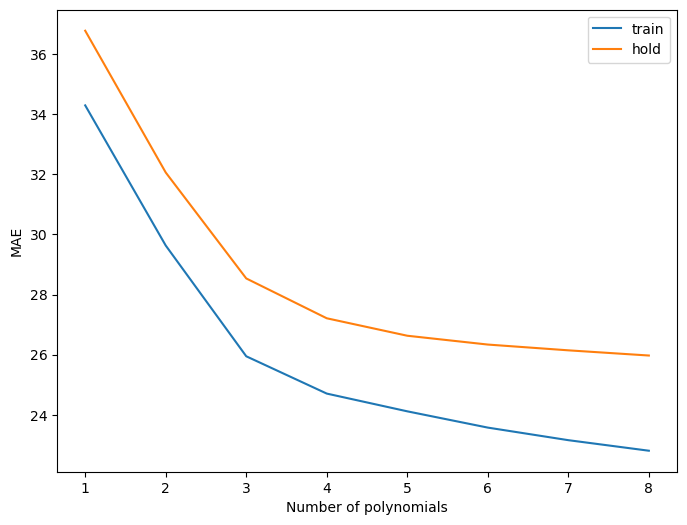

In [57]:
find_ridge_regression(X_train, y_train, X_hold, y_hold,1, 8, 0.1)

R2:  [0.7662823161406108, 0.7689069784871385]


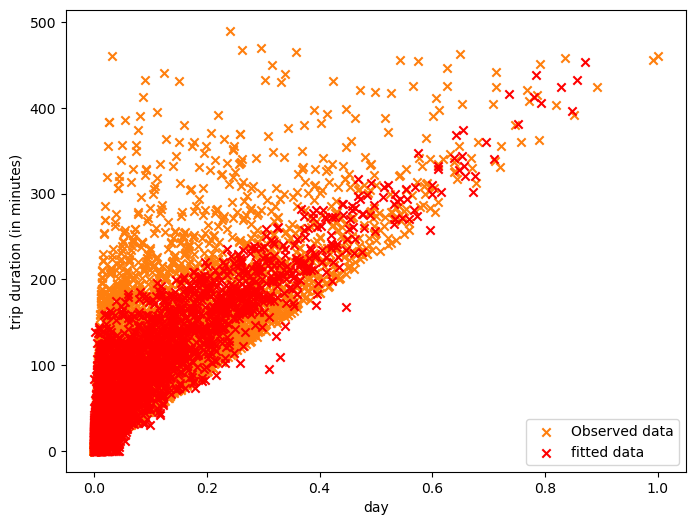

In [54]:
print("R2: ",ridge_regression(X_train_hold, y_train_hold, X_test, y_test, 6, 10, True, 'day', "r2"))

In [50]:
def tree_regression(X_train, y_train, X_hold, y_hold, degree, plot, column, method):   # method can be r2 or MAE
    # initialize model
    tree_reg = DecisionTreeRegressor(max_depth=degree)
    tree_model = tree_reg.fit(X_train, y_train) 

    # fit
    y_pred_hold = tree_model.predict(X_hold)
    y_pred_train = tree_model.predict(X_train)
    y_pred_hold[y_pred_hold < 0] = 0
    y_pred_train[y_pred_train < 0] = 0
    
    if(plot):
        plot_prediction(X_train, y_train, X_hold, y_pred_hold, column)
    
    if(method == "MAE"):
        errors = [mean_absolute_error(y_train, y_pred_train), mean_absolute_error(y_hold, y_pred_hold)]
        return errors
    elif(method == "r2"):
        r2_scores = [r2_score(y_train, y_pred_train), r2_score(y_hold, y_pred_hold)]
        return r2_scores
    else:
        return "Please select r2 or MAE as method"


def find_tree_regression(X_train, y_train, X_hold, y_hold, min_value, max_value):
    
    error = []
    error_train = []
    error_hold = []
    array = np.arange(min_value, max_value + 1)
    
    for i in array:
        errors = tree_regression(X_train, y_train, X_hold, y_hold, i, False, "weekday", "MAE")
        error_train.append(errors[0])
        error_hold.append(errors[1])
    
    # plot results
    plt.figure(figsize = (8,6))
    plt.plot(array, error_train, label="train")
    plt.plot(array, error_hold, label="hold")
    plt.legend()
    plt.xlabel("Number of polynomials")
    plt.ylabel("MAE")
    plt.show()

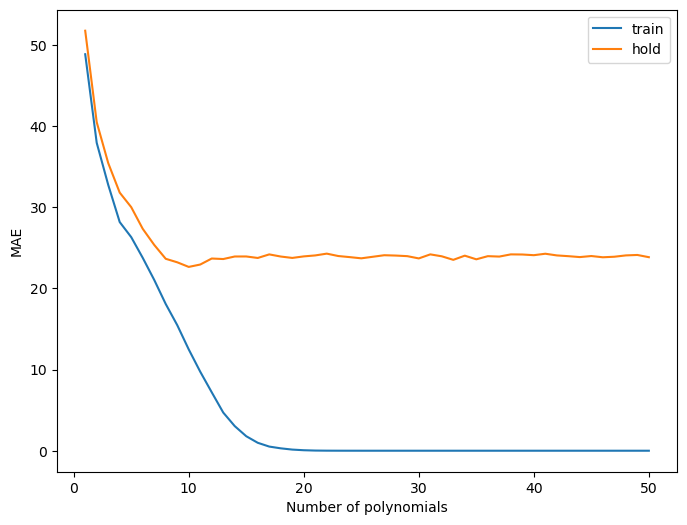

In [60]:
find_tree_regression(X_train, y_train, X_hold, y_hold, 1, 50)

MAE:  [0.9202047482442068, 0.8225284616963101]


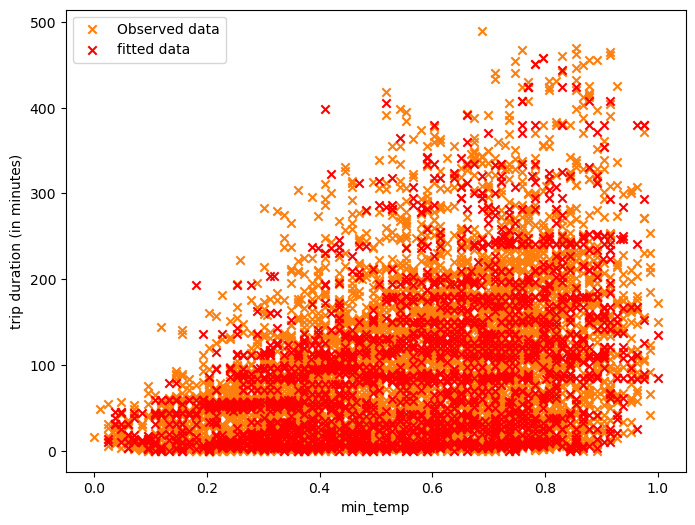

In [52]:
print("MAE: ",tree_regression(X_train_hold, y_train_hold, X_test, y_test, 10, True, "min_temp", "r2"))